In [2]:
import tensorflow as tf
import gensim
import sklearn
import nltk
nltk.download()

import konlpy
import _jpype

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [98]:
import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

import os

In [99]:
train = pd.read_csv('../input/train.csv', dtype=str)
test = pd.read_csv('../input/test.csv', dtype=str)
validation = pd.read_csv('../input/validation.csv', dtype=str)

# 한글 폰트 적용
plt.rc('font', family='Malgun Gothic') 
# 캔버스 사이즈 적용
plt.rcParams["figure.figsize"] = (12, 9)

In [158]:
train

,utterance,intent
0,NT630 Z는 어떤 제품을 구입해야 하나요?,제품
1,오늘 출고됐는데 내 일 받을 수 있는 건가요?,배송
...,...,...
65297,"나팔 등기구에 29, 30번 제품 둘 다 가능한가요?",제품
65298,연결단자 부분이 반밖에 안 들어가는데 정상인가요?,제품


In [101]:
train['intent'].unique().__len__()

13

In [102]:
train['intent'].value_counts().sort_values(ascending=False)

제품          41635
배송          15744
교환|반품|환불     2431
행사           1895
결제           1214
AS            839
구매            423
웹사이트          303
부가서비스         269
포장            253
매장            202
주문             53
멤버십            38
Name: intent, dtype: int64

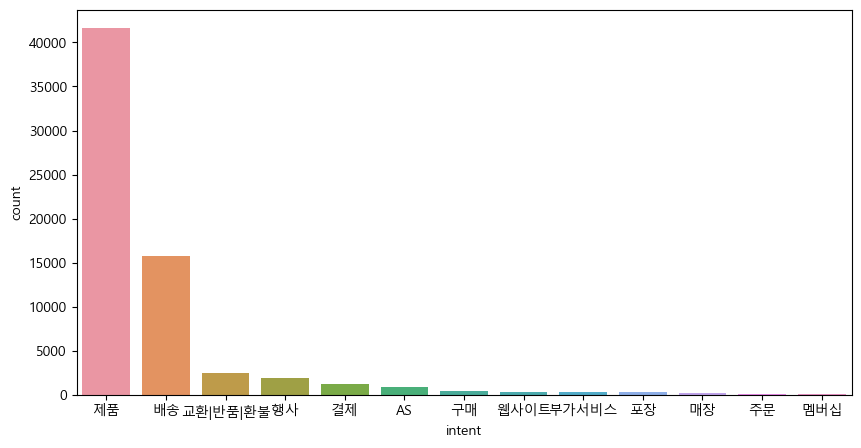

In [103]:
order = train['intent'].value_counts().sort_values(ascending=False).index

fig = plt.figure(figsize=(10,5))
plt.rc('font', family='Malgun Gothic') 
# 캔버스 사이즈 적용
plt.rcParams["figure.figsize"] = (12, 9)
sns.countplot(data = train, x = 'intent', order=order)
plt.show()

In [159]:
pd.set_option('display.max_rows', 100)

In [128]:
productCol = train[train['intent'] == '제품']
productCol

,utterance,intent
0,NT630 Z는 어떤 제품을 구입해야 하나요?,제품
3,방 한쪽 면을 하려고 하는데 길이를 어떻게 할지 애매해서 2개 이상 사야 될까요?,제품
4,거울 뒷면에 보호판이 있나요?,제품
5,800x400슈렉선반을 갖고 있는데 600x300사이즈로 변경하려고 하는데요선반과 ...,제품
8,이 스터디플래너 샘플로 속지 좀 보여주실래요?,제품
...,...,...
65290,화이트 벽지에 골드 프레임 있는 게 나을까요?,제품
65292,옵션19번 하고 옵션 20번 하고 무슨 차이인가요?,제품
65296,세트 구성에는 40 60이던데 그 사이즈는 필요 없어서 50 70으로 일단 추가 구...,제품
65297,"나팔 등기구에 29, 30번 제품 둘 다 가능한가요?",제품


In [139]:
productCol['utterance'].str.extract('(\w*)\?')[0].unique().__len__()

4268

In [161]:
productCol['utterance'].str.extract('(\w* \w*) \w*\?')

,0
0,제품을 구입해야
3,이상 사야
4,뒷면에 보호판이
5,따로 주문이
8,속지 좀
...,...
65290,있는 게
65292,하고 무슨
65296,다 보내는
65297,둘 다


In [153]:
productCol['utterance'].str.extract('(\w*)\?')[0].value_counts()

되나요                 3776
건가요                 3586
가능한가요               3065
있나요                 2712
하나요                 2462
없나요                 1212
될까요                 1082
거죠                  1013
가요                   897
맞나요                  894
있을까요                 840
가능할까요                823
입고되나요                476
할까요                  475
맞죠                   451
제품인가요                392
뭔가요                  390
재입고되나요               340
아닌가요                 292
오나요                  276
인가요                  271
호환되나요                220
가능한지요                202
괜찮을까요                200
맞을까요                 190
없을까요                 185
좋을까요                 179
않나요                  178
되는지요                 140
가능하나요                135
여                    135
포함인가요                133
입고될까요                125
나오나요                 123
괜찮나요                 118
되죠                   116
있어요                  115
얼마인가요                107
있는지요                 104
무엇인가요                103


In [150]:
productCol[productCol['utterance'].str.findall('(\w*)\?').apply(len) > 1 ]

,utterance,intent
440,질문이 영주사기랑 같이 들어있는 플라스틱들은 뭔가 여?고 무도박혀 있고 흰색 플라스...,제품
526,?흰색 라벨지 모양 없는 A4 잉크젯 전용으로 사려는 데 어느 거사면 되나요?,제품
551,설치할라믄?공구 세트 같은 거 있어야 되나요?,제품
1050,하자 없는 걸로 꼭 검수해서 보내주세요 그리고 터치미?먼지 안 날릴까요?,제품
1055,제조년월일 언제인 가용?최근 제조된 상품 보내주시나요?,제품
...,...,...
64041,레오파트 슈퍼싱글?퀸?둘 다 17키로 세탁기에 세탁되나요?,제품
64098,붙박이장 안에 일반 사각직부 등?을 센서 등으로 교체하고 싶은데 비 전문가가 LED...,제품
64325,80M 상품 2개가 와야 하는데 1개?가 왜 없나요?,제품
64538,노트북이 윈도우10인데 유에스비 사용 가능한지 제가 삼성 노트북을 사용하는 데 윈도...,제품
